In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import random
from tqdm.auto import tqdm
import imageio
import einops
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.datasets import FashionMNIST
import os
device = torch.device("cuda:0")

In [2]:
import importlib
from GAN_modules import * 
from DDGAN import *

In [3]:
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
batch_size = 64

dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size, shuffle=True)

In [4]:
def compute_gradient_penalty(netD, x_t_real,
                        x_tp1, t, x_t_fake):

    alpha = torch.tensor(np.random.random((x_t_real.size(0), 1, 1, 1)),
                         dtype=torch.float32, device=device)
    
    interpolates = (alpha * x_t_real + ((1 - alpha) * x_t_fake)).requires_grad_(True)
    d_interpolates = netD(interpolates, t, x_tp1)
    
    fake = torch.ones((x_t_real.shape[0], 1), dtype=torch.float32, device=device)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty



def training_loop(ddgan, loader, n_epochs, optimizerG, optimizerD, device, c, r1,
                  schedulerG=None, schedulerD=None, store_path="ddgan_model.pt"):

    best_loss = float("inf")
    n_steps = ddgan.n_steps
    netG = ddgan.generator
    netD = ddgan.discriminator

    pos_coeff = Posterior_Coefficients(ddgan, device)

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        print(f'Epoch {epoch+1}/{n_epochs}')
        
        epoch_errG = 0.0
        epoch_errD = 0.0
           
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            for p in netD.parameters():
                p.requires_grad = True
                        
            netD.zero_grad()
                
            x0 = batch[0].to(device)
            n = len(x0)
            
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            x_t.requires_grad = True
            
            #train D with real            
            D_real = netD(x_t, t, x_tp1.detach()).view(-1)
            errD_real = (-D_real).mean()
            
            #errD_real.backward(retain_graph=True)
            
                                           
            #train D with fake from G
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1, t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)
    
            errD_fake = (output).mean()
            #errD_fake.backward()
            
            #errD = errD_real.detach() + errD_fake.detach()
            
            gradient_penalty = compute_gradient_penalty(netD, x_t,
                                        x_tp1.data, t, x_pos_sample.data)
            
            errD = errD_real + errD_fake + r1 * gradient_penalty
            errD.backward()
            
            optimizerD.step()            
            
            #train G without D
            for p in netD.parameters():
                p.requires_grad = False

            netG.zero_grad()
            
            t = torch.randint(0, n_steps, (n,)).to(device)
            
            x_t, x_tp1 = q_sample_pairs(ddgan, x0, t)
            
            latent_z = torch.randn(n, netG.zsize).to(device)
            
            x_0_predict = netG(x_tp1.detach(), t, latent_z)
            x_pos_sample = sample_posterior(pos_coeff, x_0_predict, x_tp1, t)
            
            output = netD(x_pos_sample, t, x_tp1.detach()).view(-1)     
            
            errG = (-output).mean()
            
            errG.backward()
            optimizerG.step()

            epoch_errG += errG.detach() * n / len(loader.dataset)
            epoch_errD += errD.detach() * n / len(loader.dataset)
        
        if schedulerD is not None:
            schedulerD.step()
        if schedulerG is not None:
            schedulerG.step()

        log_string = f"G loss: {epoch_errG:.6f}, D loss: {epoch_errD:.6f}"

        # Storing the model
        torch.save(ddgan.state_dict(), store_path)
        print(log_string)
        print('-' * 75)
    torch.cuda.empty_cache()

In [47]:
from CustomizableCosineDecayScheduler import CosineDecayWithWarmUpScheduler as CD_scheduler
n_steps, min_beta, max_beta = 10, 3e-1, 9e-1
c = 0.03
r1 = 12

In [48]:
# try:
#     del generator
# except: pass
# try:
#     del discriminator
# except: pass
# try:
#     del ddgan
# except: pass
# torch.cuda.empty_cache()


# generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device, zsize=100)
# discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)


# ddgan = DDGAN(generator, discriminator, n_steps=n_steps, 
#               min_beta=min_beta, max_beta=max_beta, emb_dim=50,
#               device=device).to(device)
ddgan = best_model


optimizerG = optim.Adam(ddgan.generator.parameters(), betas=(0.7, 0.95),
                       lr=4e-6)
optimizerD = optim.Adam(ddgan.discriminator.parameters(), betas=(0.7, 0.95),
                       lr=4e-6)

schedulerG = CD_scheduler(optimizerG, 
                    max_lr=4e-6, min_lr=5e-8, num_step_down=20, 
                    num_step_up=0, gamma=0.7, alpha=0.3)
schedulerD = CD_scheduler(optimizerG, 
                    max_lr=4e-6, min_lr=5e-8, num_step_down=20, 
                    num_step_up=0, gamma=0.4, alpha=0.2)


ddgan.train()
training_loop(ddgan, loader, n_epochs=20, optimizerG=optimizerG, optimizerD=optimizerD, 
              c=c, r1=r1, schedulerG=schedulerG, schedulerD=schedulerD,
              device=device, store_path="ddgan_wd_model_r10.pt")

Training progress:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20


Epoch 1/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.682220, D loss: -0.023934
---------------------------------------------------------------------------
Epoch 2/20


Epoch 2/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -10.170346, D loss: -0.013968
---------------------------------------------------------------------------
Epoch 3/20


Epoch 3/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.918862, D loss: -0.016049
---------------------------------------------------------------------------
Epoch 4/20


Epoch 4/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.842188, D loss: -0.013896
---------------------------------------------------------------------------
Epoch 5/20


Epoch 5/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.414105, D loss: -0.013358
---------------------------------------------------------------------------
Epoch 6/20


Epoch 6/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.397938, D loss: -0.012205
---------------------------------------------------------------------------
Epoch 7/20


Epoch 7/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.311715, D loss: -0.011068
---------------------------------------------------------------------------
Epoch 8/20


Epoch 8/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.557061, D loss: -0.006644
---------------------------------------------------------------------------
Epoch 9/20


Epoch 9/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.589557, D loss: -0.011876
---------------------------------------------------------------------------
Epoch 10/20


Epoch 10/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.346466, D loss: -0.013441
---------------------------------------------------------------------------
Epoch 11/20


Epoch 11/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.475308, D loss: -0.012884
---------------------------------------------------------------------------
Epoch 12/20


Epoch 12/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.163156, D loss: -0.016534
---------------------------------------------------------------------------
Epoch 13/20


Epoch 13/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.061162, D loss: -0.020583
---------------------------------------------------------------------------
Epoch 14/20


Epoch 14/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.093477, D loss: -0.025673
---------------------------------------------------------------------------
Epoch 15/20


Epoch 15/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.229610, D loss: -0.023051
---------------------------------------------------------------------------
Epoch 16/20


Epoch 16/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.179939, D loss: -0.032139
---------------------------------------------------------------------------
Epoch 17/20


Epoch 17/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.248871, D loss: -0.029510
---------------------------------------------------------------------------
Epoch 18/20


Epoch 18/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.279579, D loss: -0.036375
---------------------------------------------------------------------------
Epoch 19/20


Epoch 19/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.645494, D loss: -0.040368
---------------------------------------------------------------------------
Epoch 20/20


Epoch 20/20:   0%|          | 0/938 [00:00<?, ?it/s]

G loss: -9.830702, D loss: -0.052282
---------------------------------------------------------------------------


In [49]:
store_path="ddgan_wd_model_r10.pt"

generator = Generator(time_emb_dim=50, n_steps=n_steps, device=device)
discriminator = Discriminator(time_emb_dim=50, n_steps=n_steps, device=device)

best_model = DDGAN(generator, discriminator, n_steps=n_steps, 
                   device=device, emb_dim=50)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print()

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

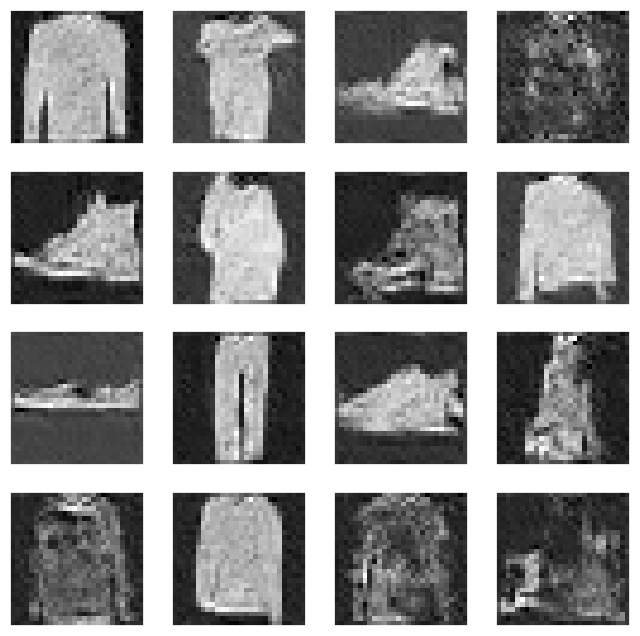

In [52]:
best_model.eval()
generated = generate_new_images(
        best_model,
        n_samples=16,
        n_steps=10
    )
show_images(generated, save_path=None)

In [8]:
# fake samples
n_samples=50000

os.makedirs(f"generated_ddgan_wd_FMNIST", exist_ok=True)

num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

for n in tqdm(num_steps, desc=f"Generating progress", colour="#00dd00"):
    
    torch.cuda.empty_cache()
    
    with torch.no_grad():

        generated = generate_new_images(
            best_model,
            n_samples=n_samples,
            n_steps=n
        )

    os.makedirs(f"generated_ddgan_wd_FMNIST/{n}", exist_ok=True)
    
    for i in range(len(generated)):
        img = generated[i]
        img -= img.min()
        img /= img.max()
        img = torch.cat([img,img,img])
        save_image(img, f"generated_ddgan_wd_FMNIST/{n}/img{i}.png")

Generating progress:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

Steps:   0%|          | 0/1 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

Steps:   0%|          | 0/2 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

Steps:   0%|          | 0/3 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

Steps:   0%|          | 0/4 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

Steps:   0%|          | 0/5 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

Steps:   0%|          | 0/6 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

Steps:   0%|          | 0/7 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

Steps:   0%|          | 0/8 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

Steps:   0%|          | 0/9 [00:00<?, ?it/s]

batches:   0%|          | 0/25 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

Steps:   0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
# extract features and calculate FID
from FID import extract_real_features, FID_score

# path_real = "datasets/FashionMNIST_png/"
# real_features = extract_real_features(path_real)

# with open('real_features.npy', "wb") as f:
#     np.save(f, real_features)
# torch.cuda.empty_cache()

with open("real_features.npy", 'rb') as f:
    real_features = np.load(f)

In [10]:
path_real = "real_features.npy"
num_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

scores = []

for n in tqdm(num_steps, leave=False, desc=f"Progress", colour="#009900"):
    torch.cuda.empty_cache()
    path_fake = f"generated_ddgan_wd_FMNIST/{n}/"
    scores.append(FID_score(path_real, path_fake, True))

with open('FID_scores_FMNIST_ddgan_wd.npy', "wb") as f:
    np.save(f, np.array(scores))

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

Feature extracting:   0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
with open('FID_scores_FMNIST_ddgan_wd.npy', "rb") as f:
    scores = np.load(f)

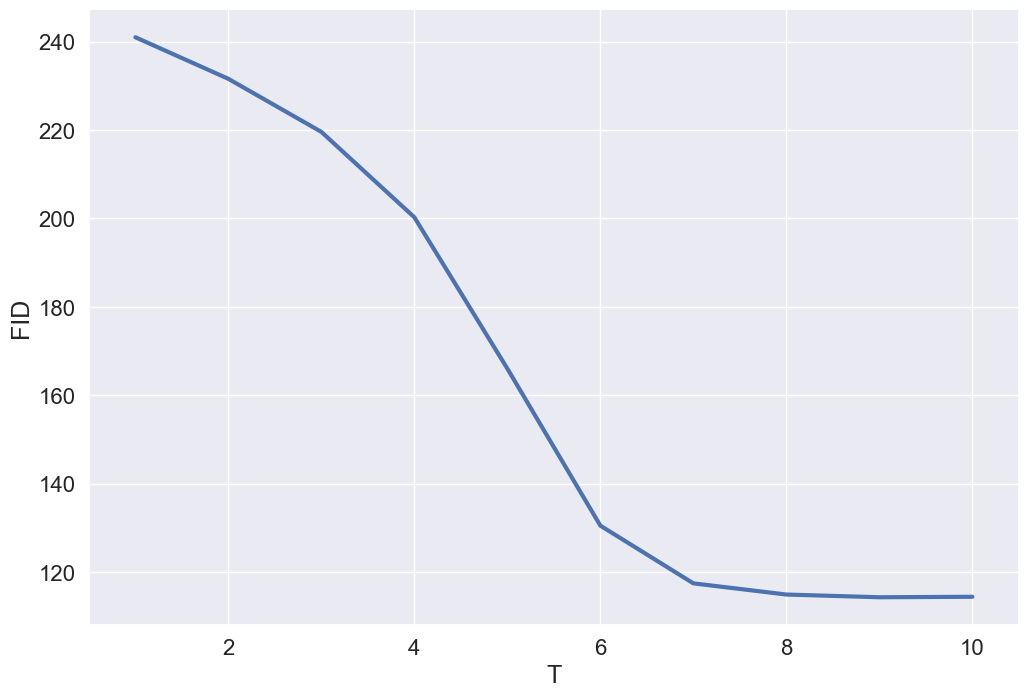

In [12]:
import seaborn as sns
sns.set_theme(style='darkgrid')

plt.figure(figsize=(12,8))

plt.plot(num_steps, scores, lw=3)

plt.xlabel("T", fontsize=18)
plt.ylabel("FID", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(left=0.5, right=10.5)

plt.savefig("DDGAN_WD_FID_FMNIST.png", bbox_inches='tight')
plt.show()